# Cloud-radiative heating in global climate model runs averaged over the NAWDEX ocean domain region

Model data is from AMIP-like control simulations of Voigt, Albern and Papavasileiou, J. Climate, 2019, The atmospheric pathway of the cloud‐radiative impact on the circulation response to global warming: Important and uncertain; https://doi.org/10.1175/JCLI-D-18-0810.1.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

## Load cloud radiative heating and sea-land mask

In [2]:
def mpi_radheating():
    
    path = '/work/bb1018/nawdex-hackathon_pp/globalmodels/'
    
    # PRP with clouds zero, this gives -1*cloud-radiative heating
    filename = path+'ecav0001_1035-1039.prp_cloudsoff.timmean.shiftedlon.nc'
    ds_crh = ( xr.open_dataset(filename)[['dQ_cld_trad', 'dQ_cld_srad','hyam','hybm']].
               rename({'dQ_cld_trad': 'dtlwcld', 'dQ_cld_srad': 'dtswcld'}).squeeze().drop('time') )
    
    # rescale heating rates by -1 * 86400, which makes units of K/day, and the -1 is to take
    # care of the zero-cloud PRP 
    ds_crh['dtlwcld'] = -86400*ds_crh['dtlwcld']
    ds_crh['dtswcld'] = -86400*ds_crh['dtswcld']
        
    # surface pressure
    filename = path+'BOT_ecav0001_1002_1041.timmean.shiftedlon.nc'
    ds_aps = xr.open_dataset(filename)['aps'].squeeze().drop('time')
    
    # merge input datasets
    # attention: some lat values of ds_aps and ds_crh are slightly different (~1e-14),
    # this is taken care of before merging the two datasets by reindex_alike
    ds_aps = ds_aps.reindex_like(ds_crh, method='nearest', tolerance=1e-5)
    ds = xr.merge([ds_crh, ds_aps]) 
                  
    # interpolate heating rates on set of common pressure levels taking into account surface pressure
    from scipy.interpolate import interp1d
    lev_int = ds['hyam']+1000e2*ds['hybm']
    dtlwcld_int = np.zeros((lev_int.size, ds.lat.size, ds.lon.size)) + np.nan
    dtswcld_int = np.zeros((lev_int.size, ds.lat.size, ds.lon.size)) + np.nan
    for j in range(ds.lat.size):
        for i in range(ds.lon.size):
            dtlwcld_int[:,j,i] = interp1d(ds['hyam']+ds['aps'][j,i]*ds['hybm'], ds['dtlwcld'][:,j,i], kind='cubic', 
                                        fill_value='extrapolate')(lev_int)    
            dtswcld_int[:,j,i] = interp1d(ds['hyam']+ds['aps'][j,i]*ds['hybm'], ds['dtswcld'][:,j,i], kind='cubic', 
                                        fill_value='extrapolate')(lev_int)    
    
    # set levels above local surface pressure to np.nan
    for k in range(lev_int.size):
        for j in range(ds.lat.size):
            for i in range(ds.lon.size):
                if ds['aps'][j,i]<lev_int[k]:
                    dtlwcld_int[k,j,i] = np.nan
                    dtswcld_int[k,j,i] = np.nan
   
    # load land-sea mask, realign_like to catch small differences of  coordinate values with respect to ds
    ds_slm = ( xr.open_dataset(path+'/echam6_slm_land1_ocean0.shiftedlon.nc').drop(['time','time_bnds']).squeeze()
               .reindex_like(ds, method='nearest', tolerance=1e-5) )
    
    # create output dataset with interpolated cloud-radiative heating and land-sea mask
    ds_out = xr.Dataset( {'dtlwcld': (['lev', 'lat', 'lon'], dtlwcld_int),
                          'dtswcld': (['lev', 'lat', 'lon'], dtswcld_int),},
                         coords={'lev': (['lev'], lev_int),
                                 'lat': ds.lat,
                                 'lon': ds.lon} )
    ds_out = xr.merge([ds_out, ds_slm])
   
    return ds_out

ds_mpi = mpi_radheating() 

/pf/b/b380459/conda-envs/Nawdex-Hackathon/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/pf/b/b380459/conda-envs/Nawdex-Hackathon/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/pf/b/b380459/conda-envs/Nawdex-Hackathon/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/pf/b/b380459/conda

In [3]:
def icon_radheating():
    
    # note: The heating rates are re-diagnosed from the radiative fluxes here
    # because for clear-sky conditions only the fluxes and not the heating
    # rates have been saved. The re-diagnosis works very well, as can be seen
    # by comparing the re-diagnosed all-sky radiative heating and the
    # all-sky radiative heating output by the model.
    #
    # Ideally, we would also screen for surface pressure and set pressure levels
    # below the surface to nan. This is not as surface pressure is not available.
    # Yet, because we are below limiting the analysis to ocean points,
    # very few -if any at all- grid points will be affected and have levels below the surface.
    
    path = '/work/bb1018/nawdex-hackathon_pp/globalmodels/'
    file = path+'ICON-NWP_prp_AMIP_free_3d_fluxes_heatingrates_mm.shiftedlon.nc'
    ds   = xr.open_dataset(file)
    
    # convert time to a format understood by xarray groub by
    ds['time'] = pd.to_datetime(ds.time.values, format='%Y%m%d')
    
    # calculate heating rates from flux divergence
    # in ICON be sure to use specific heat capacity at constant volume, not constant pressure
    cv = 1004.64 - 287.04 # specific heat of dry air for constant volume, equals cvd in mo_physical_constants of ICON model code
    factor = -86400 * 9.81 / cv 
    ds['dtsw']   = (('time', 'lev', 'lat', 'lon'), factor*np.gradient(ds['swflxall'], ds.lev,axis=1));
    ds['dtlw']   = (('time', 'lev', 'lat', 'lon'), factor*np.gradient(ds['lwflxall'], ds.lev,axis=1));
    ds['dtswcs'] = (('time', 'lev', 'lat', 'lon'), factor*np.gradient(ds['swflxclr'], ds.lev,axis=1));
    ds['dtlwcs'] = (('time', 'lev', 'lat', 'lon'), factor*np.gradient(ds['lwflxclr'], ds.lev,axis=1));
    
    # compute clour-radiative heating
    ds['dtswcld'] = ds['dtsw'] - ds['dtswcs']
    ds['dtlwcld'] = ds['dtlw'] - ds['dtlwcs']
    
    # add land-sea mask
    ds_slm = ( xr.open_dataset(path+'/icon_extpar_0010_R02B04_G.remapdis.r192x96.shiftedlon.nc')
              .rename({'FR_LAND': 'slm'})['slm'].squeeze() )    
    
    # merge and only keep land-sea mask and cloud-radiative heating
    ds = xr.merge([ds, ds_slm])[['slm', 'dtswcld', 'dtlwcld']]
    
    return ds

ds_ico = icon_radheating()

In [4]:
def lmd_radheating():
    
    path = '/work/bb1018/nawdex-hackathon_pp/globalmodels/'
    filename = path+'l5aam001_19810101_20091230.histmth.timmean.nc'
    
    ds = ( xr.open_dataset(filename)[['dtswr', 'dtlwr', 'dtsw0', 'dtlw0', 'fract_ter']]
           .rename({'presnivs': 'lev', 'fract_ter': 'slm'}).drop('time_counter').squeeze() )
    
    dtlwcld = 86400*(ds['dtlwr'] - ds['dtlw0'])
    dtswcld = 86400*(ds['dtswr'] - ds['dtsw0'])
    
    # create output dataset with  cloud-radiative heating and land-sea mask
    ds_out = xr.Dataset( {'dtlwcld': (['lev', 'lat', 'lon'], dtlwcld),
                          'dtswcld': (['lev', 'lat', 'lon'], dtswcld),},
                         coords={'lev': ds.lev,
                                 'lat': ds.lat,
                                 'lon': ds.lon} )
    ds_out = xr.merge([ds_out, ds['slm']])
    
    return ds_out
            
ds_lmd = lmd_radheating()

## Make spatial mean over NAWDEX region

The NAWDEX region is the same used for the ICON limited-area simulations: between 32N and 71N, and 63W and 24E. See postprocessing/derive_openoceanmasks.ipynb.

In [5]:
def make_nawdexmean(ds):
        
    # select lon-lat box
    aux = ( ds.sel(lat=slice(32,71),lon=slice(-63,24)) )
    # if lat is ordered from North to South, we catch this here
    if ds.lat[0]>ds.lat[1]:
        aux = ( ds.sel(lat=slice(71,32),lon=slice(-63,24)) )
    
    # average spatially over the ocean, set weights to zero over land
    weights = np.cos(np.deg2rad(aux.lat))
    weights.name = "weights"
    weights = weights * xr.where(aux['slm']<0.1, 1, 0) 
    mean = aux.weighted(weights).mean(dim=['lat','lon'])
    
    return mean

Time-mean values. Note that ICON has monthly values, MPI and LMD only have time mean values.

In [6]:
ds_ico_nawdexmean_yearmean = make_nawdexmean(ds_ico.mean('time'))
ds_mpi_nawdexmean_yearmean = make_nawdexmean(ds_mpi)
ds_lmd_nawdexmean_yearmean = make_nawdexmean(ds_lmd)

Because we have monthly values for ICON, we here also calculate the average over only the NAWDEX months September and October.

In [7]:
ds_ico_nawdexmean_seboctmean = make_nawdexmean(
    ds_ico.groupby('time.month').mean('time').sel(month=slice(9,10)).mean('month') )

## Plot the vertical profile of the cloud-radiative heating

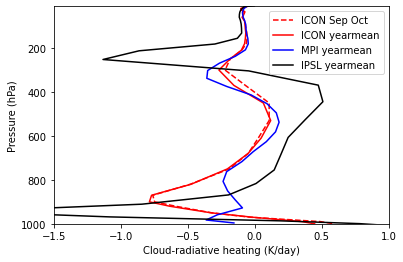

In [9]:
plt.plot(ds_ico_nawdexmean_seboctmean['dtlwcld'], ds_ico_nawdexmean_seboctmean.lev/100, 'r--', label='ICON Sep Oct')
plt.plot(ds_ico_nawdexmean_yearmean['dtlwcld'], ds_ico_nawdexmean_yearmean.lev/100, 'r', label='ICON yearmean')
plt.plot(ds_mpi_nawdexmean_yearmean['dtlwcld'], ds_mpi_nawdexmean_yearmean.lev/100, 'b', label='MPI yearmean')
plt.plot(ds_lmd_nawdexmean_yearmean['dtlwcld'], ds_lmd_nawdexmean_yearmean.lev/100, 'k', label='IPSL yearmean')
plt.xlim(-1.5,1,5)
plt.ylim(1000,10)
plt.xlabel('Cloud-radiative heating (K/day)')
plt.ylabel('Pressure (hPa)')
plt.legend()

plt.savefig('cloudradheating_nawdexmean_globalmodels.pdf')